In [1]:
#Color printing
from termcolor import colored

#General data operations library
import math
import numpy as np

#The tensorflow library
import tensorflow  as tf

#Plotting libraries
import matplotlib.pyplot as plt

#Increase plots font size
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

2025-03-25 20:43:57.164243: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-25 20:43:57.164494: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-25 20:43:57.355254: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-25 20:43:57.695293: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def getFeatures(nPoints):
    """generate data, get x and y for y = -2 + 3x + 2x^2"""
    x = tf.random.uniform((nPoints, 1), -10, 10)
    y = -2 + 3*x + 2*x**2
    return x, y

def getModel(nInputs, nHidenNeurons, nOutputNeurons, lr):
    """get the model"""
    inputs = tf.keras.Input(shape=(nInputs,), name="features")
    iLayer = 1
    layer = tf.keras.layers.Dense(nHidenNeurons,
                                name="layer_{}".format(iLayer))(inputs)
    outputs = tf.keras.layers.Dense(nOutputNeurons, name = "output")(layer)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="DNN")
    # model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), #tutaj wchodzi lr_schedule!
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), #tutaj nie wchodzi lr_schedule!
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=['MeanAbsolutePercentageError','RootMeanSquaredError'])
    return model

def plotTrainHistory(history):

    fig, axes = plt.subplots(1,2, figsize=(7,3))
    axes[0].plot(history.history['loss'], label = 'train')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss function')
    axes[0].legend(loc='upper right')

    axes[1].plot(history.history['loss'], label = 'train')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss function')
    axes[1].legend(loc='upper right')
    axes[1].set_yscale('log')

    plt.subplots_adjust(bottom=0.02, left=0.02, right=0.98, wspace=0.6)
    plt.show()

def plotPredictCompare(x, y_given, y_pred):
    "porownanie"
    fig, axes = plt.subplots(1, 2, figsize=(8,4))
    axes[0].scatter(x, y_given, linewidths=0.3, label = 'given data')
    axes[0].scatter(x, y_pred, linewidths=0.3, label = 'model prediction')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    axes[0].legend()
    "histogram"
    diff = (y[:, 0] - y_pred[:,0])/y[:, 0]
    axes[1].hist(diff, bins=np.linspace(-0.2,0.2,51))
    axes[1].set_xlabel("(true - model)/true")
    plt.subplots_adjust(bottom=0.02, left=0.02, right=0.98, wspace=0.6)
    plt.show()

In [3]:
%time
"evol model"

nPoints = 1000
x, y = getFeatures(nPoints)
x = np.hstack([x, x**2])
nInputs = 2
nHidenNeurons = 1
nOutputNeurons = 1
lr = 1E-3
model = getModel(nInputs, nHidenNeurons, nOutputNeurons, lr)
nEpochs = 300
history = model.fit(x=x, y=y, epochs=nEpochs, verbose=0)
metrics = model.evaluate(x=x, y=y)

CPU times: user 6 µs, sys: 5 µs, total: 11 µs
Wall time: 18.4 µs


2025-03-25 20:44:13.312739: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: UNKNOWN ERROR (34)


32/32 [==============================] - 0s 3ms/step - loss: 8.2373e-11 - mean_absolute_percentage_error: 0.0012 - root_mean_squared_error: 9.0760e-06


32/32 [==============================] - 0s 3ms/step


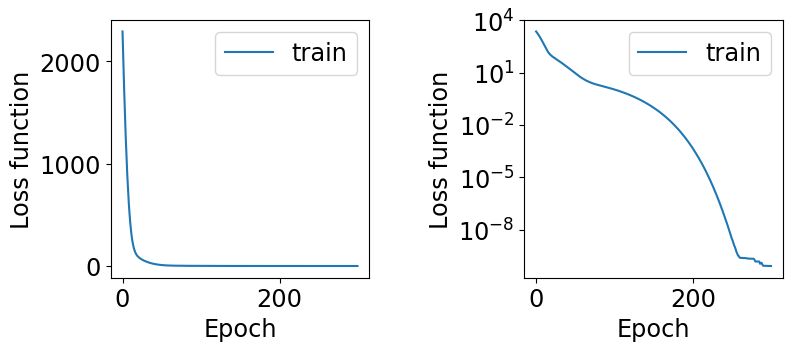

Model weights:
layer_1: [-1.375724  -0.9171495]
output: [-2.1806695]
layer_0*output: [2.9999993 2.       ]
Layers bias:
dla trójmianu 2 x^2 + 3 x - 2
a_2: 2.9999993
a_1: 2.0
a_0: -1.9999945


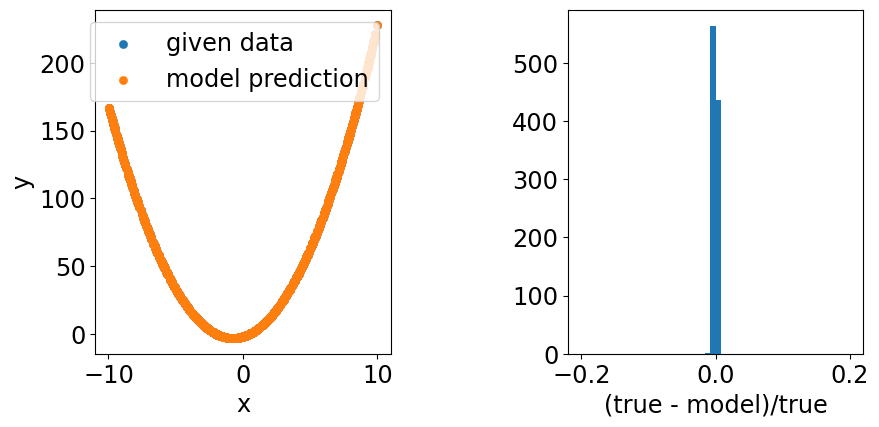

In [4]:
"historia treningu"
y_pred = model.predict(x)
plotTrainHistory(history)
"wagi"
print(colored("Model weights:","blue"))
print(colored("layer_1:","blue"), model.get_layer('layer_1').weights[0].numpy()[:,0])
print(colored("output:","blue"), model.get_layer('output').weights[0].numpy()[:,0])
finalWeight = (model.get_layer('layer_1').weights[0]*model.get_layer('output').weights[0]).numpy()[:,0]
print(colored("layer_0*output:","blue"), finalWeight[:])
"total bias"
print(colored("Layers bias:","blue"))
l1_bias = model.get_layer('layer_1').weights[1].numpy()
output_weight = model.get_layer('output').weights[0].numpy()
output_bias = model.get_layer('output').weights[1].numpy()
total_bias = l1_bias*output_weight+output_bias
"podsumowanie"
print(colored("dla trójmianu 2 x^2 + 3 x - 2", "blue"))
print(colored("a_2:", "magenta"), finalWeight[0])
print(colored("a_1:","magenta"), finalWeight[1])
print(colored("a_0:","magenta"), total_bias[0][0])
finalWeight = np.append(finalWeight,total_bias)
"porownanie dopasowania i histogram"
plotPredictCompare(x[:, 0], y, y_pred)
